In [1]:
import numpy as np
import pandas as pd
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
if __name__ == "__main__" and __package__ is None:
    from sys import path
    from os.path import dirname as dir

    path.append(dir(path[0]))
    __package__ = "examples"
from utils.date_utils import get_doy

### User input

In [28]:
savedir = '/media/michaeltrs/sdb/HD2/Data/Satellite_Imagery/ARISE/Tanzania/PRODUCTS'
# '/media/michaeltrs/sdb/HD2/Data/Satellite_Imagery/RadiantEarth/Sentinel2/SSudan'
# '/media/michaeltrs/0a8a5a48-ede5-47d0-8eff-10d11350bf98/Satellite_Data/Sentinel2/France/T31TFL/2018'
# '/media/michaeltrs/0a8a5a48-ede5-47d0-8eff-10d11350bf98/Satellite_Data/Sentinel2/Senegal/Niakhar_GT_SAMPLES_2018/cloud_0_10'
year = '2020'
date_range = ('0101', '1030')  # (mindate: 'mmdd', maxdate: 'mmdd')
cloudcoverpercentage = (0, 50)   # (min %, max %)
minprodsize = 500                # Mb
numproducts = 26
tile = '37MCN'  # '37MCP' # '35PNK' # '35PMK' # '30PZR'  # '30PYR'  # '31TFL'  # '31TGN'  # '28PCB'  #'31TEN'  # '31TEL'  # '31TDM'  #'31TFM'
platformname = 'Sentinel-2'
processinglevel = 'Level-1C'

### Read user credentials

In [29]:
cred = pd.read_csv("pw.csv", header=None)

### Query for Sentinel products

In [30]:
api = SentinelAPI(cred[0][0], cred[0][1])  # , 'https://scihub.copernicus.eu/dhus')
print("querying...")
products = api.query(tileid=tile,
                     platformname=platformname,
                     cloudcoverpercentage=cloudcoverpercentage,
                     date=("%s%s" % (year, date_range[0]), "%s%s" % (year, date_range[1])),
                     processinglevel=processinglevel)
df = api.to_dataframe(products)
print("found %d products" % len(products))

querying...
found 66 products


### Remove very small size products

In [31]:
# df['datatakesensingstart'].values

In [32]:
sizes = np.array([float(s.split(" ")[0]) for s in df['size'].values])
products2keep = OrderedDict()
for i, prodkey in enumerate(list(products.keys())):
    if sizes[i] >= minprodsize:
        # print(sizes[i])
        products2keep[prodkey] = products[prodkey]
df2keep = api.to_dataframe(products2keep).reset_index()
print("keeping %d products with larger than %dMb" % (len(products2keep), minprodsize))

if len(products2keep) < numproducts:
    print("number of products found (%d) is less than initially selected (%d)" % (len(products2keep), numproducts))
    print("changing number of selected products to %d" % (len(products2keep)))
    print("you may want to change selection criteria in 'User input' cell to find more products")
    numproducts = len(products2keep)

keeping 31 products with larger than 500Mb


### Spread products evenly in time and visualize

In [33]:
ccfactor = 0.0    # cloud cover factor when selecting products
def distance(doys, target_doy, ccfactor=0):
    """
    distance function for selecting products depending on 
    proximity to desired date and cloud cover
    """
    dist = np.abs(doys['doy'] - target_doy) + ccfactor * doys['cloudcoverpercentage']
    return dist

    doy       size cloudcoverpercentage
0     1  785.34 MB               3.5737
1    11  807.48 MB              28.3172
2    36  798.48 MB              27.0181
3    46  720.30 MB              40.6635
4    51  816.05 MB              40.4272
5    66  769.21 MB               9.9869
6    76  765.91 MB              39.4886
7    86  805.80 MB              23.1502
8    96  792.27 MB              37.5002
9   106  786.40 MB              40.7784
10  141  787.27 MB              24.0731
11  146  813.88 MB              46.4327
12  151  813.74 MB              13.3712
13  156  803.82 MB               8.5439
14  171  805.30 MB              45.3986
15  181  822.32 MB              49.9576
16  196  802.69 MB              26.3661
17  206  767.24 MB               4.3674
18  216  819.81 MB              27.0017
19  226  768.43 MB              39.6511
20  246  796.62 MB              44.2618
21  256  823.44 MB              26.1624
22  266  805.06 MB              48.8255
23  276  824.94 MB              38.3304


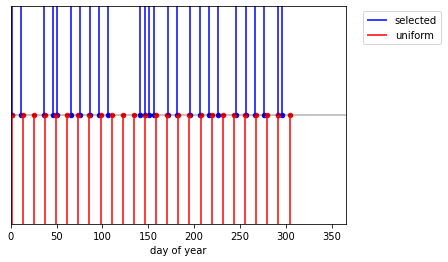

In [34]:
start_doy = get_doy("%s%s" % (year, date_range[0]))
end_doy = get_doy("%s%s" % (year, date_range[1]))
uniform_doy_list = np.linspace(start_doy, end_doy, numproducts).tolist()

doys = df2keep.copy()  # [['datatakesensingstart', 'cloudcoverpercentage', 'size']]
doys['doy'] = pd.DataFrame(
    doys['datatakesensingstart'].apply(lambda s: get_doy(str(s).split(' ')[0].replace('-', ''))))

idx_list = []
for doy_ in uniform_doy_list:
    # print(doy_)
    doys['distance'] = distance(doys, doy_, ccfactor)
    idx = doys['distance'].argmin()
    idx_list.append(pd.DataFrame(doys.iloc[idx, :]).T)
    doys = doys.drop(index=idx).reset_index(drop=True)
prod2keep = pd.concat(idx_list).reset_index(drop=True)  # df2keep.iloc[idx_list].reset_index(drop=True)
prod2keep['doy'] = pd.DataFrame(
    prod2keep['datatakesensingstart'].apply(lambda s: get_doy(str(s).split(' ')[0].replace('-', ''))))

# visualize
plt.scatter(prod2keep['doy'].values, np.zeros(prod2keep.shape[0]), s=20, c='b')
plt.scatter(uniform_doy_list, np.zeros(len(uniform_doy_list)), s=20, c='r')
plt.vlines(prod2keep['doy'].values, 0, 1, color='b', label='selected')
plt.vlines(uniform_doy_list, 0, -1, color='r', label='uniform')
plt.hlines(0, 1, 365, color='k', alpha=0.3)
plt.ylim(-1, 1)
plt.xlim(0, 365)
plt.yticks([], [])
plt.xlabel('day of year')
plt.legend(bbox_to_anchor=(1.3, 1))

# examine
print(prod2keep[['doy', 'size', 'cloudcoverpercentage']])  # .columns)

### Save selected products to disk

In [35]:
savename = '%s/%s_%s_tile%s_minsize%dMb_%ddates_year%s_from%sto%s_mincc%dmaxcc%d.csv' % \
           (savedir, platformname, processinglevel, tile, minprodsize, numproducts, year, 
            date_range[0], date_range[1], cloudcoverpercentage[0], cloudcoverpercentage[1])

if not os.path.exists(os.path.dirname(savename)):
    print("making new directory %s" % os.path.dirname(savename))
    os.makedirs(os.path.dirname(savename))

print("saving products info to %s" % savename)
prod2keep.to_csv(savename, index=False)

saving products info to /media/michaeltrs/sdb/HD2/Data/Satellite_Imagery/ARISE/Tanzania/PRODUCTS/Sentinel-2_Level-1C_tile37MCN_minsize500Mb_26dates_year2020_from0101to1030_mincc0maxcc50.csv


In [8]:
prod2keep

,index,title,link,link_alternative,link_icon,summary,ondemand,datatakesensingstart,beginposition,endposition,...,tileid,hv_order_tileid,filename,identifier,uuid,level1cpdiidentifier,granuleidentifier,datastripidentifier,doy,distance
0,2ce69250-b68d-40b4-ba6e-ecbf1ef288bd,S2A_MSIL1C_20160103T102432_N0201_R065_T30PZR_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2016-01-03T10:24:32.029Z, Instrument: MS...",false,2016-01-03 10:24:32.029,2016-01-03 10:24:32.029,2016-01-03 10:24:32.029,...,30PZR,PR30Z,S2A_MSIL1C_20160103T102432_N0201_R065_T30PZR_2...,S2A_MSIL1C_20160103T102432_N0201_R065_T30PZR_2...,2ce69250-b68d-40b4-ba6e-ecbf1ef288bd,S2A_OPER_MSI_L1C_TL_SGS__20160103T193031_A0027...,S2A_OPER_MSI_L1C_TL_SGS__20160103T193031_A0027...,S2A_OPER_MSI_L1C_DS_SGS__20160103T193031_S2016...,3,2
1,0cd90b8e-5a26-40e3-9a21-208f01d91550,S2A_MSIL1C_20160113T102402_N0201_R065_T30PZR_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2016-01-13T10:24:02.029Z, Instrument: MS...",false,2016-01-13 10:24:02.029,2016-01-13 10:24:02.029,2016-01-13 10:24:02.029,...,30PZR,PR30Z,S2A_MSIL1C_20160113T102402_N0201_R065_T30PZR_2...,S2A_MSIL1C_20160113T102402_N0201_R065_T30PZR_2...,0cd90b8e-5a26-40e3-9a21-208f01d91550,S2A_OPER_MSI_L1C_TL_SGS__20160113T160447_A0029...,S2A_OPER_MSI_L1C_TL_SGS__20160113T160447_A0029...,S2A_OPER_MSI_L1C_DS_SGS__20160113T160447_S2016...,13,3.15
2,00f292f7-9f20-4406-b492-805586c71759,S2A_MSIL1C_20160123T102322_N0201_R065_T30PZR_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2016-01-23T10:23:22.029Z, Instrument: MS...",false,2016-01-23 10:23:22.029,2016-01-23 10:23:22.029,2016-01-23 10:23:22.029,...,30PZR,PR30Z,S2A_MSIL1C_20160123T102322_N0201_R065_T30PZR_2...,S2A_MSIL1C_20160123T102322_N0201_R065_T30PZR_2...,00f292f7-9f20-4406-b492-805586c71759,S2A_OPER_MSI_L1C_TL_SGS__20160123T193953_A0030...,S2A_OPER_MSI_L1C_TL_SGS__20160123T193953_A0030...,S2A_OPER_MSI_L1C_DS_SGS__20160123T193953_S2016...,23,8.3
3,2c981510-ba86-4351-bf44-7416fc68b4ff,S2A_MSIL1C_20160212T102132_N0201_R065_T30PZR_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2016-02-12T10:21:32.031Z, Instrument: MS...",false,2016-02-12 10:21:32.031,2016-02-12 10:21:32.031,2016-02-12 10:21:32.031,...,30PZR,PR30Z,S2A_MSIL1C_20160212T102132_N0201_R065_T30PZR_2...,S2A_MSIL1C_20160212T102132_N0201_R065_T30PZR_2...,2c981510-ba86-4351-bf44-7416fc68b4ff,S2A_OPER_MSI_L1C_TL_SGS__20160212T174440_A0033...,S2A_OPER_MSI_L1C_TL_SGS__20160212T174440_A0033...,S2A_OPER_MSI_L1C_DS_SGS__20160212T174440_S2016...,43,3.45
4,8089d23a-f0c2-4015-afd1-066d219c30df,S2A_MSIL1C_20160303T102022_N0201_R065_T30PZR_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2016-03-03T10:20:22.03Z, Instrument: MSI...",false,2016-03-03 10:20:22.030,2016-03-03 10:20:22.030,2016-03-03 10:20:22.030,...,30PZR,PR30Z,S2A_MSIL1C_20160303T102022_N0201_R065_T30PZR_2...,S2A_MSIL1C_20160303T102022_N0201_R065_T30PZR_2...,8089d23a-f0c2-4015-afd1-066d219c30df,S2A_OPER_MSI_L1C_TL_MTI__20160303T203413_A0036...,S2A_OPER_MSI_L1C_TL_MTI__20160303T203413_A0036...,S2A_OPER_MSI_L1C_DS_MTI__20160303T203413_S2016...,63,1.4
5,cbc40819-a37e-4833-b7e9-35a32d4877d7,S2A_MSIL1C_20160313T102022_N0201_R065_T30PZR_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2016-03-13T10:20:22.03Z, Instrument: MSI...",false,2016-03-13 10:20:22.030,2016-03-13 10:20:22.030,2016-03-13 10:20:22.030,...,